In [2]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
df = pd.read_csv('SeaPlaneTravel.csv')
df.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


Convert DataFrame to time series with daily frequency

In [5]:
#Using Date data as DataFrane index/label
df['Month'] = pd.to_datetime(df['Month'])
indexed_df = df.set_index('Month')

ts = indexed_df['#Passengers']
ts.head(5)
indexed_df.head(5)

,#Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121


/home/junxiong/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


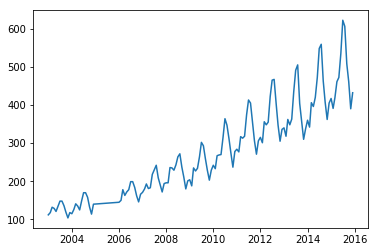

In [6]:
# Visualize this time series to see how the number of Passengers is trending 
plt.plot(ts)

Month
2003-12-31    126.666667
2004-12-31    139.666667
2005-12-31           NaN
2006-12-31    170.166667
2007-12-31    197.000000
Freq: A-DEC, Name: #Passengers, dtype: float64

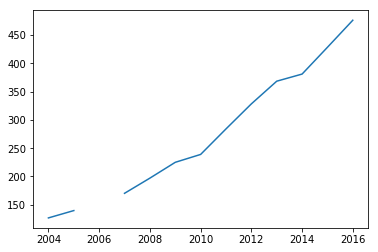

In [8]:
# Resample the data by week.
# We will use this sample to predict the Euro traffic rates 
ts_year = ts.resample('Y').mean()
plt.plot(ts_year)
ts_year.head()

In [9]:
# This use for visualize testing stationarity purpose
# window is number of lags
# However, we might not always be able to make such visual inferences

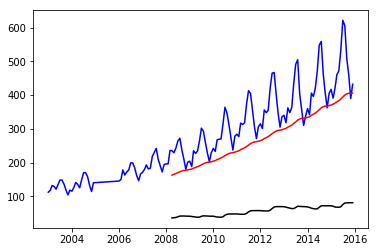

In [12]:
rolmean = ts.rolling(window=52,center=False).mean() 
rolstd = ts.rolling(window=52,center=False).std()
plt.plot(ts, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.show()

# Applying Dickey-Fuller test:
- Because the test statistic is less than 1% critical value (0.815369 > -2.578770) 
- p-value is larger than 0.05 
- The moving average is not constant over time and null hypothesis of the Dickey-Fuller test cannot be rejected.
- This shows that this weekly time series is not stationary

In [13]:
#Applying Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# Repair the time series before applying ARIMA
We need to transform the time series into a stationary time series

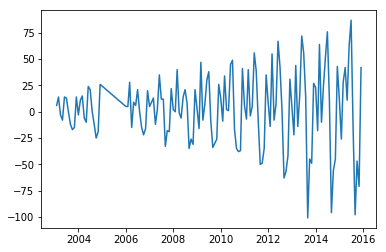

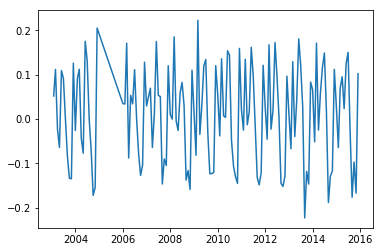

In [14]:
#Applying differencing to stationarize the data
ts_diff = ts - ts.shift()
plt.plot(ts_diff)
plt.show()

#Perform log transformation prior differencing for better results
ts_log = np.log(ts) #log make normal distrubition (time usually right skew)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)



# Confirm with Dicky Fuller test
- The test statistic is less than 10% critical value (-2.717131 < -2.578960) shows that this your time series is stationary with 90% confidence. 
- Now we can apply statistical model ARIMA

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


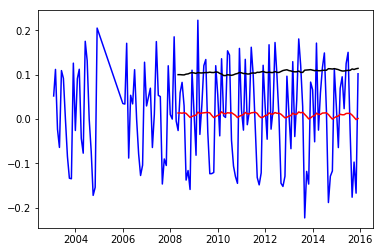

In [15]:
# Drop na data
ts_log_diff.dropna(inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

rolmean = ts_log_diff.rolling(window=52,center=False).mean() 
rolstd = ts_log_diff.rolling(window=52,center=False).std()
plt.plot(ts_log_diff, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.show()

# Determine p,d, and q paramater of ARIMA model using ACF and PACF


In [16]:
#ACF and PACF
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

/home/junxiong/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

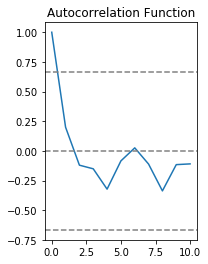

In [17]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

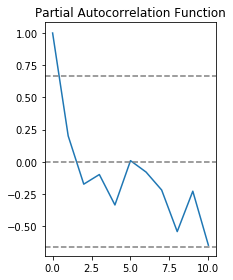

In [18]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Observer from the plots:
- p: The lag value where the PACF cuts off (drops to 0) for the first time. p = 2
- q: The lag value where the ACF charts crosses the upper confidence interval for the first time. q = 1
- Optimal model should be ARIMA(2,1,1)

/home/junxiong/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/junxiong/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.1753')

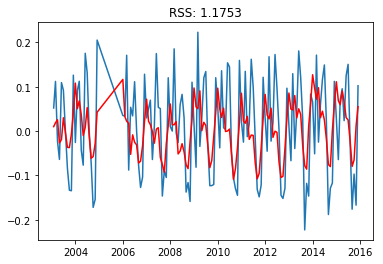

In [19]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Tue, 16 Jul 2019   AIC                           -270.151
Time:                        19:17:37   BIC                           -255.337
Sample:                             1   HQIC                          -264.131
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0101      0.000     23.507      0.000       0.009       0.011
ar.L1.D.#Passengers     0.9983      0.076     13.163      0.000       0.850       1.147
ar.L2.D.#Passeng

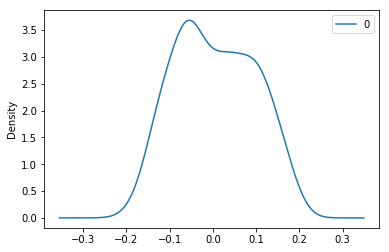

In [20]:
# Print the ARIMA result
print(results_ARIMA.summary())

# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [21]:
# Make prediction
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
2003-02-01    0.010077
2003-03-01    0.018746
2003-04-01    0.025568
2003-05-01   -0.026626
2003-06-01   -0.019247
dtype: float64

# Scaling the prediction
Scale them back to original scale
- Remove the differencing
- Take the exponent to restore the prediction back to original scale

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: 192.6999')

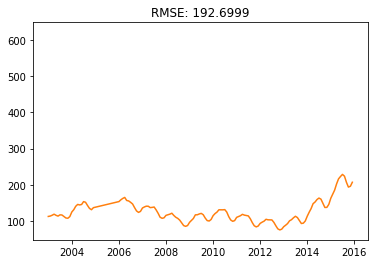

In [23]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
# plt.plot(ts_week_log)
# plt.plot(predictions_ARIMA_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

# Split the data to training/testing set

In [25]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

In [26]:

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=406.221594, expected=432.000000


In [27]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.010385


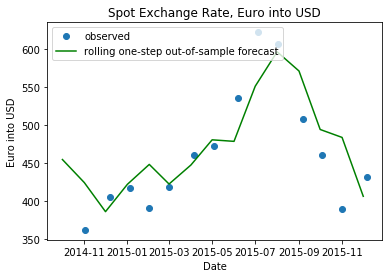

In [28]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')